In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import json

from pathlib import Path

import tensorflow as tf

from sklearn.model_selection import train_test_split

from src import utils

2022-04-27 16:40:00.915420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 16:40:00.915443: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Deep models for the spectroscopy challenge
This notebook is a playground that can be used to visualise the structure of the neural models used for the spectroscopy challenge, train the available models, and execute them on the provided test set.

In [3]:
full_data = Path('..', 'data', 'full_dataset.xlsx')
train_path = Path('..', 'data', 'raw_train.csv')
test_path = Path('..', 'data', 'raw_test.csv')

Train and test datasets can be read from previously saved `csv` files If not available, they will be created. Once the data are loaded, outliers are removed and the training set is shuffled using a fixed random seed, shared across all our working groups.

In [4]:
train_df = utils.read_raw_data(full_data, train_path, 0)
test_df = utils.read_raw_data(full_data, test_path, 1)

train_df = train_df[train_df['col1'] >= 1]
test_df = test_df[test_df['col1'] >= 1]

train_df = train_df.sample(frac=1, random_state=0)

Labels can then be extracted from the training dataset, and kept ready for further mapping.

In [5]:
X_pandas = train_df.drop(['Diet'], axis=1)

y = train_df['Diet']
y = y.map({'GRS': 0, 'CLV': 1, 'TMR': 2}).values

# train_labels can be used to create stratified splits later
train_labels = y.reshape((y.shape[0], 1))

y = tf.one_hot(y, depth=3).numpy()

2022-04-27 16:40:06.832673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-27 16:40:06.832711: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 16:40:06.832734: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (oldbox): /proc/driver/nvidia/version does not exist
2022-04-27 16:40:06.833066: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Waves can be reshaped depending on whether they will be used in a fully connected model or in a convolutional model. Moreover, the data modality can be specified as either full, thus including all the wave components, or reduced, thus excluding water regions.

In [6]:
train_waves = utils.convert_waves_linear(
    X_pandas, normalize=True, cut_water=True)

Once the data are fully loaded, we can create a simple train/validation/test split to later train our model.

In [7]:
T_X, test_X, T_y, test_y = train_test_split(
    train_waves, y, stratify=train_labels, test_size=0.4, random_state=0)

training_X, validation_X, training_y, validation_y = train_test_split(
    T_X, T_y, stratify=T_y, test_size=0.2)

## Fully connected network
In order to create a model, the `get_model` function can be invoked. It is enough to specify the type of model, the data modality and the log folder.

In [10]:
model, callbacks = utils.get_model(
    'fcn', 'full', Path('..', 'logs', 'fit', 'test_model'))

tensorboard_callback = callbacks['tensorboard']
earlystopping_callback = callbacks['early_stopping']

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1060)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1086464   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)              

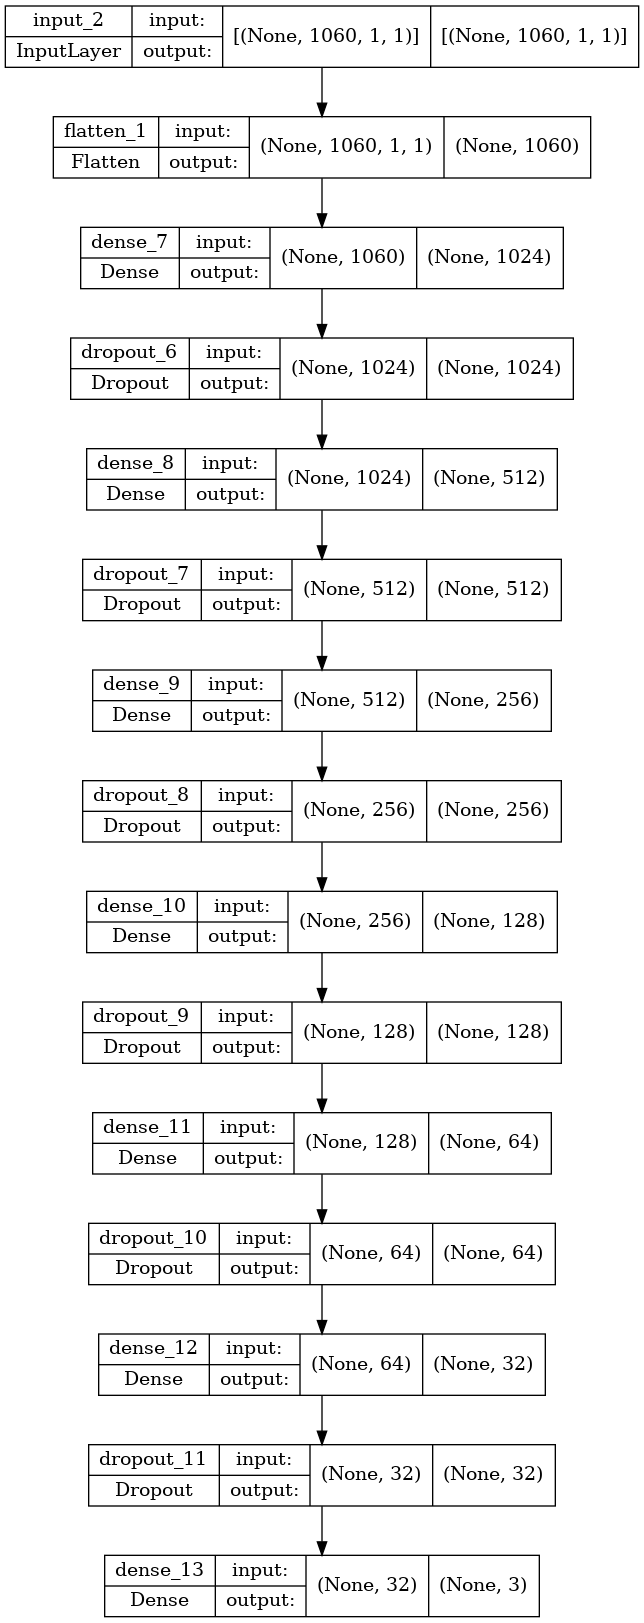

In [11]:
tf.keras.utils.plot_model(
    model,
    to_file="model_full.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

Once the model is created, we can start the training. If we decide so, the training history can be saved as a dictionary, independently from the tensorboard callback, so that later we can explore it without the need for tensorboard.

In [ ]:
# BEWARE! if you are running this with no GPU support, it will be extremely slow!
# use a small number of epochs if you are only looking at how the code works!
# epochs = 50_000
epochs = 500

# set verbose level to 0 in order to suppress training output
history = model.fit(
    training_X, training_y,
    validation_data=(validation_X, validation_y),
    epochs=epochs,
    batch_size=training_X.shape[0],
    callbacks=[earlystopping_callback, tensorboard_callback],
    verbose=1)

After the training is done, we can save both the model and the training history. We can then evaluate the model performance on the test set.

In [ ]:
model_path = Path('..', 'models', 'test_model')

model.save(model_path)
json.dump(history.history,
          open(Path(model_path, 'history.json'), 'w'))

In [ ]:
test_loss, test_acc = model.evaluate(test_X,  test_y, verbose=2)
print(f'Test accuracy: {test_acc} (loss {test_loss})')